In [1]:
# Import needed libraries
from fireTS.models import NARX
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from matplotlib import pyplot as plt
%matplotlib inline

/home/dhan/miniconda3/envs/ML/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.regression module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Import dataset
data = pd.read_excel('Data/newData.xlsx')

y = data.loc[:, ['HT','AC'] ]
X = data.loc[:, ['To','RD','Td','RH'] ]
# # X for NARX: X = X and Y
# X = np.append(X, y, axis=1)

# Split dataset
# Data test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.05, shuffle=False, random_state=15)
# Data train and Data validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=(15/95), shuffle=False, random_state=2019)
# delete temporary data
del X_temp, y_temp

# print proportions
print('train: {}% | validation: {}% | test {}%'.format(round(len(y_train)/len(y)*100,2),
                                                        round(len(y_val)/len(y)*100,2),
                                                        round(len(y_test)/len(y)*100,2)))

train: 80.0% | validation: 15.0% | test 5.0%


In [3]:
# Control design (MLP-NARX)
mdl_MLP = MLPRegressor(random_state = 1, hidden_layer_sizes=(91), max_iter = 5000)

p_value, q_value, d_value = 1, [3]*4, [0]*4
mdl_NARX = NARX(mdl_MLP, auto_order=p_value, exog_order=q_value, exog_delay=d_value)

In [4]:
# score function
def kinerja(y_target, y_pred, method="evar"):
    mask = np.isnan(y_target) | np.isnan(y_pred)
    if method == "evar":
        return explained_variance_score(y_target[~mask], y_pred[~mask])
    elif method == "r2":
        return r2_score(y_target[~mask], y_pred[~mask])
    elif method == "mse":
        return mean_squared_error(y_target[~mask], y_pred[~mask])
    elif method == "mae":
        return mean_absolute_error(y_target[~mask], y_pred[~mask])

In [5]:
y_test = y_test.sample(frac=1)

### SET AC

In [6]:
# Controller Training
mdl_NARX.fit(X_train, y_train.AC)

In [7]:
# Prediction
y_pred = mdl_NARX.predict(X_val, y_val.AC, step=1)
y_pred = pd.Series(y_pred, index=y_val.index)

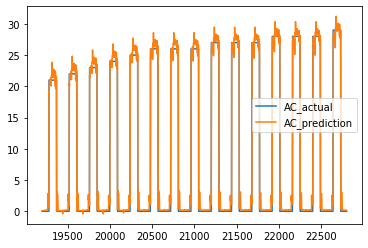

In [8]:
# Plot result
y_val.AC.plot(label='AC_actual')
y_pred.plot(label='AC_prediction')
plt.legend()

In [9]:
# Performance Evaluation
y_pred = mdl_NARX.predict(X_test, y_test.AC, step=1)
y_pred = pd.Series(y_pred, index=y_test.index)

EVar = round(kinerja(y_test.AC, y_pred, method='evar')*100, 2)
R2   = round(kinerja(y_test.AC, y_pred, method='r2')*100, 2)
RMSE = round(kinerja(y_test.AC, y_pred, method='mse')**0.5, 2)
MAE  = round(kinerja(y_test.AC, y_pred, method='mae'), 2)
print("Performance evaluation based on Test Data")
print("EVar = {}% | R2 = {}% | RMSE = {} | MAE = {}".format(EVar, R2, RMSE, MAE))
print()

Performance evaluation based on Test Data
EVar = -74.87% | R2 = -74.88% | RMSE = 18.95 | MAE = 14.05



### SET Heater

In [10]:
# Controller Training
mdl_NARX.fit(X_train, y_train.HT)

In [11]:
# Prediction
y_pred = mdl_NARX.predict(X_val, y_val.HT, step=1)
y_pred = pd.Series(y_pred, index=y_val.index)

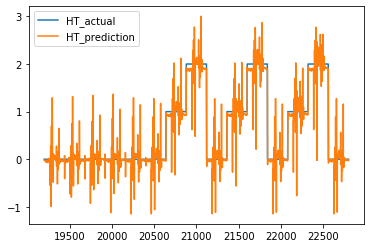

In [12]:
# Plot result
y_val.HT.plot(label='HT_actual')
y_pred.plot(label='HT_prediction')
plt.legend()

In [13]:
# Performance Evaluation
y_pred = mdl_NARX.predict(X_test, y_test.HT, step=1)
y_pred = pd.Series(y_pred, index=y_test.index)

EVar = round(kinerja(y_test.HT, y_pred, method='evar')*100, 2)
R2   = round(kinerja(y_test.HT, y_pred, method='r2')*100, 2)
RMSE = round(kinerja(y_test.HT, y_pred, method='mse')**0.5, 2)
MAE  = round(kinerja(y_test.HT, y_pred, method='mae'), 2)
print("Performance evaluation based on Test Data")
print("EVar = {}% | R2 = {}% | RMSE = {} | MAE = {}".format(EVar, R2, RMSE, MAE))
print()

Performance evaluation based on Test Data
EVar = -97.93% | R2 = -98.25% | RMSE = 1.05 | MAE = 0.82

